# NCAA Pitch Type Model EDA & Model Evaluation

### By: Mojisoluwa (Jiso) Awe


This is the exploratory data analysis and model evaluation I did at the start of the project. My intent for this project was intended to create a model that can accurately predict pitch types, but specifically tailored to college players. College players generally have less defined pitch shapes, compared to most professional baseball players.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')
import shap
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv('NCAA_Pitch.csv')
data.head(5)

,id,PitchNo,Date,Time,PAofInning,PitchofPA,PitcherId,PitcherThrows,PitcherTeam,BatterId,...,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,GameID
0,6,6,2021-04-07,15:03:45,1,6,1.000080e+09,Right,TOW_TIG,1.000059e+09,...,NaN,High,High,High,Medium,Medium,NaN,NaN,NaN,57
1,16,16,2021-04-07,15:08:11,3,4,1.000080e+09,Right,TOW_TIG,1.000101e+09,...,NaN,High,High,High,High,High,NaN,NaN,NaN,57
2,32,32,2021-04-07,15:16:17,3,4,1.000025e+09,Right,NAV_MID,1.000059e+09,...,NaN,High,High,High,High,High,NaN,NaN,NaN,57
3,34,34,2021-04-07,15:18:22,1,2,1.000080e+09,Right,TOW_TIG,1.000013e+09,...,NaN,High,High,High,Medium,High,NaN,NaN,NaN,57
4,38,38,2021-04-07,15:19:48,2,4,1.000080e+09,Right,TOW_TIG,1.000059e+09,...,NaN,High,High,High,Medium,Medium,NaN,NaN,NaN,57


In [3]:
#list(data.columns)

For the in depth descriptions of each of these metrics visit Trackman's metric glossary: https://support.trackmanbaseball.com/hc/en-us/articles/5089413493787-V3-FAQs-Radar-Measurement-Glossary-Of-Terms

# Exploratory Data Analysis
### Movement Plots

I created the movement plots for both left and right handed pitchers, to highlight the difference in their movement profiles. Traditionally in baseball, velocity in combination with horizontal and induced vertical break are used to identify pitch type.

Left and right handed pitchers have opposite horizontal movements patterns so I will be creating seperate visualizations to highlight the differences in the movement patterns.

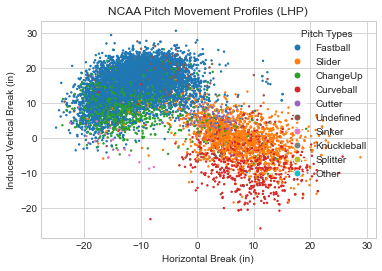

<Figure size 864x576 with 0 Axes>

In [4]:
#leftie pitch plots
dataL = data[data['PitcherThrows'] == "Left"]
xL = dataL['HorzBreak']
yL = dataL['InducedVertBreak']
zL = dataL['TaggedPitchType']

pitch_types = zL.unique()

color_map = plt.get_cmap('tab10')
color_dict = {pitch_type: color_map(i) for i, pitch_type in enumerate(pitch_types)}

color_values = [color_dict[pitch_type] for pitch_type in zL]


scatter = plt.scatter(xL, yL, c = color_values, s = 2, label = zL)

plt.title("NCAA Pitch Movement Profiles (LHP)")
plt.ylabel("Induced Vertical Break (in)")
plt.xlabel("Horizontal Break (in)")

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i / len(pitch_types)), markersize=7) for i, pitch_type in enumerate(pitch_types)]
labels = pitch_types
plt.legend(handles, labels, title = 'Pitch Types')
plt.figure(figsize = (12, 8))
plt.show()

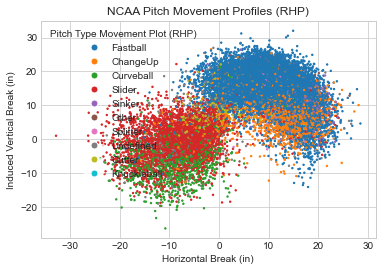

<Figure size 864x576 with 0 Axes>

In [5]:
#rightie pitch plots
dataR = data[data['PitcherThrows'] == "Right"]
xR = dataR['HorzBreak']
yR = dataR['InducedVertBreak']
zR = dataR['TaggedPitchType']

pitch_types = zR.unique()

color_map = plt.get_cmap('tab10')
color_dict = {pitch_type: color_map(i) for i, pitch_type in enumerate(pitch_types)}

color_values = [color_dict[pitch_type] for pitch_type in zR]


scatter = plt.scatter(xR, yR, c = color_values, s = 2, label = zR)

plt.title("NCAA Pitch Movement Profiles (RHP)")
plt.ylabel("Induced Vertical Break (in)")
plt.xlabel("Horizontal Break (in)")

handles = [plt.Line2D([0], [0], marker='o', 
                      color='w', 
                      markerfacecolor=color_map(i / len(pitch_types)), 
                      markersize=7) for i, 
           pitch_type in enumerate(pitch_types)]

labels = pitch_types
plt.legend(handles, labels, title = 'Pitch Type Movement Plot (RHP)')
plt.figure(figsize = (12, 8))
plt.show()

## Preprocessing

In [6]:
#Updating the data to include only the pitching related columns
cols = ['PitcherThrows', 'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis',
            'RelHeight', 'RelSide', 'Extension', 'VertBreak', 'InducedVertBreak', 'HorzBreak', 'ZoneSpeed',
           'VertApprAngle', 'HorzApprAngle', 'PitchTrajectoryXc0','PitchTrajectoryXc1', 'PitchTrajectoryXc2',
            'PitchTrajectoryYc0', 'PitchTrajectoryYc1', 'PitchTrajectoryYc2', 'PitchTrajectoryZc0',
            'PitchTrajectoryZc1','PitchTrajectoryZc2', 'TaggedPitchType', 'Tilt']

updated_df = data[cols]


In [7]:
updated_df.head(5)

,PitcherThrows,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,RelHeight,RelSide,Extension,VertBreak,...,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,TaggedPitchType,Tilt
0,Right,87.7942,-2.316140,-1.48219,2074.21,193.273,6.39639,1.25232,5.62407,-14.4967,...,-128.294,14.9429,6.39219,-5.07470,-5.88970,-1.25003,3.25817,-2.44303,Fastball,12:30:00
1,Right,78.6510,-3.237650,-2.15585,1743.14,176.354,6.21378,1.55537,5.58387,-20.2948,...,-114.773,12.5362,6.20956,-6.39518,-6.43732,-1.55554,4.33739,0.04007,ChangeUp,12:00:00
2,Right,83.7694,-0.945851,-3.61505,2063.13,194.331,5.58439,2.96050,6.79323,-21.0996,...,-122.319,13.0979,5.58271,-1.97702,-8.59524,-2.95833,7.68082,-2.47728,Fastball,12:30:00
3,Right,87.2288,-2.433030,-1.51020,2049.19,183.578,6.36527,1.16780,5.48250,-12.4688,...,-127.431,15.7290,6.36003,-5.26725,-4.85992,-1.16691,3.34104,-1.01793,Fastball,12:00:00
4,Right,88.3147,-3.345550,-1.49199,2083.12,195.554,6.32208,1.41026,5.61121,-13.4307,...,-128.939,15.3537,6.31744,-7.41420,-5.19747,-1.40755,3.28298,-2.93283,Fastball,12:30:00


In [8]:
# conversion for HB + HorzApprAngle and then implement this back into the OG DF, THEN run the models
def left_to_right_movement(data):
    tilt_mapping = {
        '11:45:00':'12:15:00','11:30:00': '12:30:00','11:15:00':'12:45:00','11:00:00':'01:00:00', 
        '10:45:00':'01:15:00', '10:30:00':'01:30:00','10:15:00':'01:45:00','10:00:00':'02:00:00',
        '09:45:00':'02:15:00','09:30:00':'02:30:00','09:15:00':'02:45:00','09:00:00':'03:00:00',
        '08:45:00':'03:15:00','08:30:00':'03:30:00','08:15:00':'03:45:00','08:00:00':'04:00:00',
        '07:45:00':'04:15:00','07:30:00':'04:30:00','07:15:00':'04:45:00','07:00:00':'05:00:00',
        '06:45:00':'05:15:00','06:30:00':'05:30:00','06:15:00':'05:45:00',
        '05:45:00':'06:15:00','05:30:00':'06:30:00','05:15:00':'06:45:00','05:00:00':'07:00:00',
        '04:45:00':'07:15:00','04:30:00':'07:30:00','04:15:00':'07:45:00','04:00:00':'08:00:00',
        '03:45:00':'08:15:00','03:30:00':'08:30:00','03:15:00':'08:45:00','03:00:00':'09:00:00',
        '02:45:00':'09:15:00','02:30:00':'09:30:00','02:15:00':'09:45:00','02:00:00':'10:00:00',
        '01:45:00':'10:15:00','01:30:00':'10:30:00','01:15:00':'10:45:00','01:00:00':'11:00:00'}
    
    if data['PitcherThrows'].iloc[0] == 'Left':
        data['Tilt'] = data['Tilt'].map(tilt_mapping)
        
    for col in ['HorzBreak', 'RelSide', 'HorzRelAngle', 'HorzApprAngle', 'PitchTrajectoryZc0', 'PitchTrajectoryZc1', 'PitchTrajectoryZc2']:
        if col in data.columns:
            data[col] = data[col]*-1
            
    data = data.drop('PitcherThrows', axis=1)
    return data



In [9]:
data = left_to_right_movement(updated_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
data['Tilt_minutes'] = (pd.to_timedelta(data['Tilt']).dt.total_seconds())/60
updated_df = data.drop("Tilt", axis = 1)
updated_df

,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,...,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,TaggedPitchType,Tilt_minutes
0,87.7942,-2.316140,1.48219,2074.21,193.2730,6.39639,-1.25232,5.62407,-14.4967,22.71110,...,-128.294,14.9429,6.39219,-5.07470,-5.88970,1.25003,-3.25817,2.44303,Fastball,750.0
1,78.6510,-3.237650,2.15585,1743.14,176.3540,6.21378,-1.55537,5.58387,-20.2948,26.51700,...,-114.773,12.5362,6.20956,-6.39518,-6.43732,1.55554,-4.33739,-0.04007,ChangeUp,720.0
2,83.7694,-0.945851,3.61505,2063.13,194.3310,5.58439,-2.96050,6.79323,-21.0996,17.81280,...,-122.319,13.0979,5.58271,-1.97702,-8.59524,2.95833,-7.68082,2.47728,Fastball,750.0
3,87.2288,-2.433030,1.51020,2049.19,183.5780,6.36527,-1.16780,5.48250,-12.4688,25.74060,...,-127.431,15.7290,6.36003,-5.26725,-4.85992,1.16691,-3.34104,1.01793,Fastball,720.0
4,88.3147,-3.345550,1.49199,2083.12,195.5540,6.32208,-1.41026,5.61121,-13.4307,23.49540,...,-128.939,15.3537,6.31744,-7.41420,-5.19747,1.40755,-3.28298,2.93283,Fastball,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37054,77.8320,0.487803,-3.79674,1629.89,89.1505,4.96262,1.48449,6.13498,-44.7470,1.22839,...,-113.748,10.7878,4.96757,0.83277,-15.51590,-1.47783,7.37037,-7.06468,ChangeUp,540.0
37055,91.9834,-3.016400,-2.31560,2055.19,160.8450,6.28585,1.78022,6.68517,-10.5206,22.21320,...,-134.281,17.1792,6.28117,-6.94342,-4.54720,-1.77695,5.33487,-4.07897,Fastball,675.0
37056,91.0094,-2.001200,-1.25103,2068.34,164.7750,6.39009,1.82484,6.42173,-15.1611,18.67500,...,-132.998,17.3268,6.38689,-4.55699,-6.78894,-1.82261,2.84045,-2.49379,Fastball,690.0
37057,92.2731,-3.173200,-2.67958,2148.68,154.7450,6.25661,1.89786,6.70419,-11.4928,20.70590,...,-134.710,15.8895,6.25298,-7.36801,-5.08098,-1.89428,6.19644,-5.13710,Fastball,675.0


## Model Evaluation (Part 1)

Here I wanted to examine various models and see what their performance looks like after encoding desired categorical metrics. Categorical data is important to have included here because it can provide some further context to the model, which will impact the models ability to learn and make accurate predictions.

In [11]:
updated_df = updated_df.dropna()
y = updated_df['TaggedPitchType']
X = updated_df.drop('TaggedPitchType', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

#### KNN

In [12]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_pred_knn = knn.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_knn))

Training Accuracy:  0.8481401227880101
Test Accuracy:  0.7975300617484563


#### SVM

In [13]:
svc = SVC(kernel = 'rbf', random_state = 2)
svc.fit(X_train, y_train)
y_train_SVC = svc.predict(X_train)
y_pred_SVC = svc.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, y_train_SVC))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_SVC))

Training Accuracy:  0.7689779703864211
Test Accuracy:  0.7583143754739465


#### Naive Bayes

In [14]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
y_train_nb = gnb.predict(X_train)

print("Training Accuracy: ", accuracy_score(y_train, y_train_nb))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_gnb))

Training Accuracy:  0.7202600216684724
Test Accuracy:  0.72083197920052


#### Decision Tree

In [15]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_train_dt = dt.predict(X_train)

print("Training Accuracy: ", accuracy_score(y_train, y_train_dt))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_dt))

Training Accuracy:  1.0
Test Accuracy:  0.7910302242443938


The accuracy scores are lower than I had anticipated and so I decided to look into the distribution of the pitch type data for further insight.

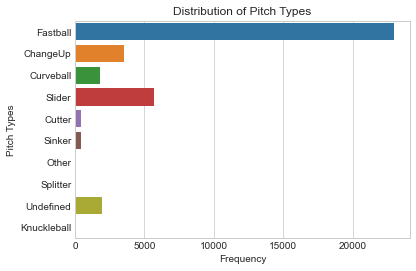

In [16]:
sns.countplot(y = updated_df['TaggedPitchType'])
plt.title('Distribution of Pitch Types')
plt.xlabel('Frequency')
plt.ylabel('Pitch Types')
plt.show()

Generally, when one is referring to the "fastball", they are talking about the four-seam fastball. The sinker is a two-seam fastball and at the collegiate level, many people just refer to sinkers as fastballs. The distinction between the two pitch types comes from the way that the pitcher orients the seams of the ball when throwing it. The sinker tends to have more horizontal movement / armside movement (run). Opposed to the traditional four-seam fastball which has more vertical movement and is more resistant to "dropping" (ride).

For the purposes of this project, seeing as I'm trying to predict college pitch types, I'll be categorizing sinkers as fastballs. Additionally, due to the data imbalance for certain pitch types (Other, Splittler, Undefined, and Knuckleball), these pitch types will be excluded from the dataset to ensure more reliable model performance. 

In [17]:
# function to remove uncommon pitch types
def pitch_type_adjust(data):
    data['TaggedPitchType'] = data['TaggedPitchType'].replace('Sinker', 'Fastball')
        
    nope = ['Other', 'Splitter', 'Undefined', 'Knuckleball']
    data[~data['TaggedPitchType'].isin(nope)]
        
    return data
    

In [18]:
updated_df = pitch_type_adjust(updated_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
#updated_df = updated_df.dropna()
y = updated_df['TaggedPitchType']
X = updated_df.drop('TaggedPitchType', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

## Model Selection (Post Pitch Type Adjustments)
#### KNN

In [20]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_pred_knn = knn.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_knn))

Training Accuracy:  0.8595882990249187
Test Accuracy:  0.8108547286317842


#### SVM

In [21]:
svc = SVC(kernel = 'rbf', random_state = 2)
svc.fit(X_train, y_train)

y_train_SVC = svc.predict(X_train)
y_pred_SVC = svc.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, y_train_SVC))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_SVC))

Training Accuracy:  0.7802094618996027
Test Accuracy:  0.7673058173545662


#### Naive Bayes

In [22]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)
y_train_nb = gnb.predict(X_train)

print("Training Accuracy: ", accuracy_score(y_train, y_train_nb))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_gnb))

Training Accuracy:  0.7610689779703864
Test Accuracy:  0.7578810529736757


#### Decison Tree

In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_train_dt = dt.predict(X_train)

print("Training Accuracy: ", accuracy_score(y_train, y_train_dt))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_dt))

Training Accuracy:  1.0
Test Accuracy:  0.8033799155021124


# Feature Importance

Here I will be calculating feature importance using the permutation importance function. This function will examine each individual feature and see how much it influences the overall model accuracy.

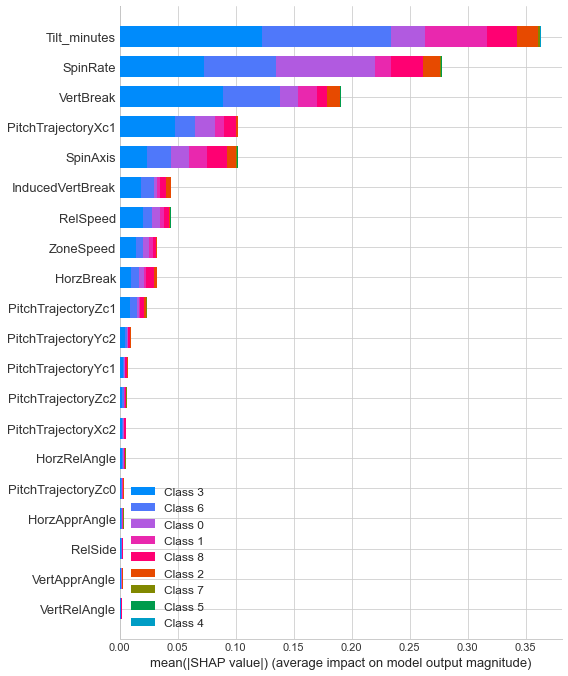

In [24]:
# subsetting the training data used for computation
background = X_train.sample(n = 100, random_state = 42)
X_test_sample = X_test.sample(n = 300, random_state = 42)
explainer = shap.KernelExplainer(knn.predict_proba, background)

# Compute SHAP values for the training data
shap_values = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values, X_test_sample)

Through examining the feature importance displayed in this visualization, I was able to filter the data to include the metrics would aid the model's success.

# Hyperparameter Tuning

In [164]:
grid_params = {'n_neighbors' : range(0, 15),
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'euclidean', 'manhattan']}

In [165]:
gsearch = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = grid_params,
                 verbose = 1, cv = 3, n_jobs = -1)

In [166]:
gres = gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


/Users/jisoluawe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   58.2s finished


In [167]:
print('Best Accuracy Score:', gres.best_score_)
print('Best Params:', gres.best_params_)

Best Accuracy Score: 0.8413145539906103
Best Params: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
